In [35]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(font_scale=1.5)
sns.set_style("ticks")
%matplotlib inline

### Processing GNBR requires extra datasets
* cleanGNBR.py: requires genesAndTaxa and meshChebiOMIMMappings
* download: gene_info (5.1G), gen_history (804Mb) from https://ftp.ncbi.nlm.nih.gov/gene/DATA/
* download taxdmp.zip from https://ftp.ncbi.nih.gov/pub/taxonomy/
* download MeSH ASCII bin files https://www.nlm.nih.gov/databases/download/mesh.html
* download Titles file from OMIM https://www.omim.org/downloads
* download Names file from CHEBI from https://ftp.ebi.ac.uk/pub/databases/chebi/Flat_file_tab_delimited/

Additional files to process these data.
* checkSpeciesOfGenes.py: 
* meSHChebiOMIM_mapping.py

### Processing the GNBR .txt files downloaded from Zenodo

### Steps

1. `python createMapping.py --partiis ../part-ii-dependency-paths-chemical-gene-sorted-with-themes.txt --outFile entities.tsv2`

2. `python processGNBR.py --entities entities.tsv2 --parti ../part-i-chemical-gene-path-theme-distributions.txt --partii ../part-ii-dependency-paths-chemical-gene-sorted-with-themes.txt --outFile gnbr.chemical-gene.tsv`


3. `python gatherGenesWithTaxa.py --ncbiGeneInfo ../gene_info --ncbiGeneHistory ../gene_history --taxonomyNames ../taxdmp/names.dmp --taxonomyMerged ../taxdmp/merged.dmp --outFile ../gene_with_taxa.tsv`


### Not sure what's the geneID file to use.
- `python checkSpeciesOfGenes.py --geneIDs ../gnbr.chemical-gene.tsv --ncbiGeneInfo ../gene_info --ncbiGeneHistory ../gene_history --taxonomyNames ../taxdmp/names.dmp --taxonomyMerged ../taxdmp/merged.dmp --outFile ../gene_matched_species.tsv`



### Map Entity IDs:
Map entity id to names. Required for loading the graph.

`python createMapping.py --partiis ../part-ii-dependency-paths-chemical-gene-sorted-with-themes.txt --outFile entities.tsv2`

In [14]:
entity = pd.read_csv("entities.tsv2", on_bad_lines='skip', sep="\t", header=None, names=["Entity_Type", "ID", "Name"])

In [15]:
entity.head()

,Entity_Type,ID,Name
0,Chemical,NaN,carboxyl
1,Gene,3164,hormone_receptor
2,Gene,10280,Sig-1R
3,Gene,65036(Tax:10116),cholinesterase
4,Gene,30816,Env


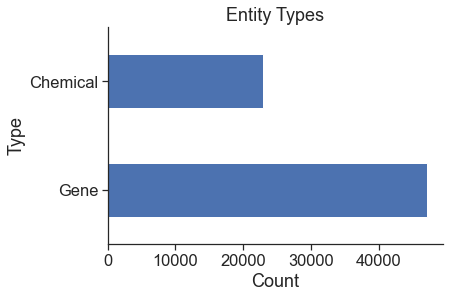

In [28]:
entity['Entity_Type'].value_counts().plot.barh()
plt.title("Entity Types")
plt.xlabel('Count')
plt.ylabel('Type')
sns.despine()

In [30]:
entity.describe()

,Entity_Type,ID,Name
count,69982,69980,69981
unique,2,69980,53103
top,Gene,3164,catalase
freq,47118,1,58


### Merge and process GNBR data
Merge the mapped entities, assoicated percentile and classifications of edges to entity pairs. 

`python processGNBR.py --entities entities.tsv2 --parti ../part-i-chemical-gene-path-theme-distributions.txt --partii ../part-ii-dependency-paths-chemical-gene-sorted-with-themes.txt --outFile gnbr.chemical-gene.tsv`

In [31]:
names = ["theme", "percentile", "PubMed ID", "First entity type (Chemical, Gene, Disease)", "First entity name, database ID(s)", "name1", "Second entity type (Chemical, Gene, Disease)", "Second entity name, database ID(s)", "name2", "sentence"]
df = pd.read_csv("gnbr.chemical-gene.tsv", on_bad_lines='skip',sep="\t", header=None, names=names)

In [4]:
df.head()

,theme,percentile,PubMed ID,"First entity type (Chemical, Gene, Disease)","First entity name, database ID(s)",name1,"Second entity type (Chemical, Gene, Disease)","Second entity name, database ID(s)",name2,sentence
0,E+,0.999976,17046567,Chemical,MESH:C524814,10058-F4,Gene,4609,c-myc,"A small-molecule <b>c-Myc</b> inhibitor , <b>1..."
1,Z,0.994259,16214042,Chemical,MESH:C071737,1035-amino_acid,Gene,57478,USP31S1,One cDNA encodes a <b>1035-amino acid</b> long...
2,B,0.998975,9809072,Chemical,MESH:C000591384,phospho-tyrosines_1052,Gene,8720,S1P,"The cDNA encodes <b>S1P</b> , an intraluminal ..."
3,A+,0.989815,15642460,Chemical,MESH:C004219,106-137,Gene,820,LL-37,"The <b>CAP18</b> ( <b>106-137</b> ) peptide , ..."
4,A+,0.989815,15642460,Chemical,MESH:C004219,106-137,Gene,820,LL-37,The binding efficacy of the <b>CAP18</b> ( <b>...


![title](nihms-1061181-f0001.jpg)

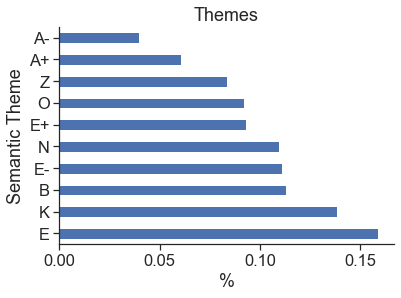

In [33]:
df['theme'].value_counts(normalize=True).plot.barh() # title/label
plt.title("Themes")
plt.xlabel('%')
plt.ylabel('Semantic Theme')
sns.despine()

### Map gene ID to taxanomay
Check the species of genes from GNBR data, needed for `cleanGNBR`

`python gatherGenesWithTaxa.py --ncbiGeneInfo ../gene_info --ncbiGeneHistory ../gene_history --taxonomyNames ../taxdmp/names.dmp --taxonomyMerged ../taxdmp/merged.dmp --outFile ../gene_with_taxa.tsv`

In [7]:
gene = pd.read_csv("gene_with_taxa.tsv", on_bad_lines='skip', sep="\t", header=None, names=["ID", "Symbol", "TaxID", "TaxName"])

In [8]:
gene

,ID,Symbol,TaxID,TaxName
0,67441593,dnaA,24,Shewanella putrefaciens
1,67441594,dnaN,24,Shewanella putrefaciens
2,67441595,recF,24,Shewanella putrefaciens
3,67441596,gyrB,24,Shewanella putrefaciens
4,67441597,JEZ96_RS00025,24,Shewanella putrefaciens
...,...,...,...,...
38198083,72188183,M0R89_RS23250,2938695,Halorussus sp. XZYJT49
38198084,72188184,M0R89_RS23255,2938695,Halorussus sp. XZYJT49
38198085,72188185,hisI,2938695,Halorussus sp. XZYJT49
38198086,72188186,M0R89_RS23265,2938695,Halorussus sp. XZYJT49


### Create a graph from the Dataframe
Generate graph object from pd.DataFrame

In [50]:
df.head()

,theme,percentile,PubMed ID,"First entity type (Chemical, Gene, Disease)","First entity name, database ID(s)",name1,"Second entity type (Chemical, Gene, Disease)","Second entity name, database ID(s)",name2,sentence
0,E+,0.999976,17046567,Chemical,MESH:C524814,10058-F4,Gene,4609,c-myc,"A small-molecule <b>c-Myc</b> inhibitor , <b>1..."
1,Z,0.994259,16214042,Chemical,MESH:C071737,1035-amino_acid,Gene,57478,USP31S1,One cDNA encodes a <b>1035-amino acid</b> long...
2,B,0.998975,9809072,Chemical,MESH:C000591384,phospho-tyrosines_1052,Gene,8720,S1P,"The cDNA encodes <b>S1P</b> , an intraluminal ..."
3,A+,0.989815,15642460,Chemical,MESH:C004219,106-137,Gene,820,LL-37,"The <b>CAP18</b> ( <b>106-137</b> ) peptide , ..."
4,A+,0.989815,15642460,Chemical,MESH:C004219,106-137,Gene,820,LL-37,The binding efficacy of the <b>CAP18</b> ( <b>...


In [36]:
# Construct the graph from processed DataFrame
# https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html?highlight=dataframe
G = nx.from_pandas_edgelist(df.iloc[:50], "name1", "name2", ["theme", "percentile"])

In [67]:
G['10058-F4']['c-myc']

{'theme': 'E+', 'percentile': 0.9999761480538004}

In [54]:
list(G.nodes)[:10]

['10058-F4',
 'c-myc',
 '1035-amino_acid',
 'USP31S1',
 'phospho-tyrosines_1052',
 'S1P',
 '106-137',
 'LL-37',
 'WP1066',
 'vinculin']

In [60]:
list(G.edges)[:10]

[('10058-F4', 'c-myc'),
 ('c-myc', 'calcitriol'),
 ('c-myc', '1,2-dimethylhydrazine'),
 ('c-myc', '12-O-tetradecanoylphorbol-13-acetate'),
 ('c-myc', '15d-PGJ2'),
 ('c-myc', '17-AAG'),
 ('c-myc', 'estradiol'),
 ('c-myc', '4-chlorobenzoyl_berbamine'),
 ('c-myc', '4-hydroxynonenal'),
 ('c-myc', '4-hydroxytamoxifen')]

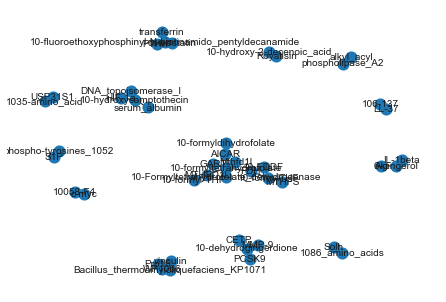

In [46]:
nx.draw_spring(G, node_size=50, with_labels=True, linewidths=5, font_size=10)

### Save graph to .png using pygraphviz

In [71]:
A = nx.nx_agraph.to_agraph(G)
A.draw("chemical_gene_gnbr.png", prog="dot") 

### Reading and writing graphs

In [ ]:
nx.write_gexf(G, "gnbr_chemical_gene.gexf") # or other common formats gml, json, pickle.

### Load networkx Graph for Pytorch-geometric use
* Loading: https://stackoverflow.com/questions/70452465/how-to-load-in-graph-from-networkx-into-pytorch-geometric-and-set-node-features
* Training: https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8

In [76]:
from torch_geometric.utils.convert import from_networkx

In [77]:
pyg_graph = from_networkx(G)

In [80]:
pyg_graph

Data(edge_index=[2, 722], theme=[722], percentile=[722], num_nodes=404)